In [46]:
%env CUDA_VISIBLE_DEVICES=6

env: CUDA_VISIBLE_DEVICES=6


In [47]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
# import tensorflow
# from tensorflow import keras
# from tensorflow.keras import layers

In [48]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchinfo import summary

In [49]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 0. Підготовка

Варіанти даних:
1. https://keras.io/2.16/api/datasets/cifar10/
2. https://keras.io/2.16/api/datasets/fashion_mnist/
3. https://keras.io/2.16/api/datasets/mnist/

Задачі:
- Завантажте вибірку із keras
- Зберіть архітекуру для 10-ти класової класифікації
- Протестуйте що вона працює, викликавши функцію predict
- Модель навчатимите в інших частинах роботи!!!

Варіанти архітектур нейромереж:
1. Lenet
2. Alexnet

Links:
- https://keras.io/api/datasets/mnist/

In [51]:
cifar = torchvision.datasets.CIFAR10(
    root="./data/cifar10", 
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Files already downloaded and verified


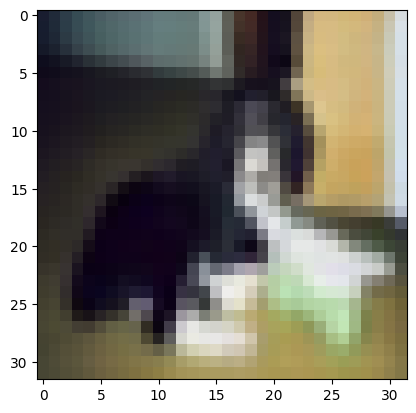

In [52]:
img = cifar[128][0].permute(1, 2, 0)
plt.imshow(img)
plt.show()

In [53]:
class KindaLeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.ModuleList([
            nn.Conv2d(3, 18, 5),
            nn.Tanh(),
            nn.AvgPool2d(2, 2),
            nn.Tanh(),
            nn.Conv2d(18, 54, 5),
            nn.Tanh(),
            nn.AvgPool2d(2, 2),
            nn.Tanh(),
            nn.Conv2d(54, 405, 5),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(405, 200),
            nn.Tanh(),
            nn.Linear(200, 10),
        ])
    
    def reset_params(self):
        for layer in self.layers:
            if hasattr(layer, "reset_parameters"):
                layer.reset_parameters()


    def forward(self, x):
        
        for layer in self.layers:
            x = layer(x)

        return x


In [54]:
model = KindaLeNet()
sample = cifar[0][0].unsqueeze(0)

model(sample)

tensor([[-0.0380,  0.0447, -0.0558, -0.0374,  0.1025, -0.0849,  0.0661, -0.0897,
          0.0355, -0.0012]], grad_fn=<AddmmBackward0>)

In [55]:
summary(model, input_size=(64, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
KindaLeNet                               [64, 10]                  --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [64, 18, 28, 28]          1,368
│    └─Tanh: 2-2                         [64, 18, 28, 28]          --
│    └─AvgPool2d: 2-3                    [64, 18, 14, 14]          --
│    └─Tanh: 2-4                         [64, 18, 14, 14]          --
│    └─Conv2d: 2-5                       [64, 54, 10, 10]          24,354
│    └─Tanh: 2-6                         [64, 54, 10, 10]          --
│    └─AvgPool2d: 2-7                    [64, 54, 5, 5]            --
│    └─Tanh: 2-8                         [64, 54, 5, 5]            --
│    └─Conv2d: 2-9                       [64, 405, 1, 1]           547,155
│    └─Tanh: 2-10                        [64, 405, 1, 1]           --
│    └─Flatten: 2-11                     [64, 405]                 --
│  

#  1. As is in RAM

- навчіть 10 епох нейромережі-класифікатора 
- скільки сумарно часу витрачено?

In [79]:
batch_size = 256 
n_epochs = 15 
dataloader = DataLoader(cifar, batch_size=batch_size, shuffle=True)

In [80]:
torch.manual_seed(42)
model.reset_params()
model = model.to(device)

In [81]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)


loss_history = []
loss_epoch = []
epoch_size = len(dataloader)
data_iterator = iter(dataloader)

for it in tqdm(range(epoch_size * n_epochs)):
    try:
        inputs, labels = next(data_iterator) 
    except StopIteration:
        data_iterator = iter(dataloader)
        inputs, labels = next(data_iterator) 

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    out = model(inputs)
    loss = loss_fn(out, labels)

    loss_history.append(loss.item())

    loss.backward()
    optimizer.step()

    if it % epoch_size == 0:
        loss_epoch.append(np.mean(loss_history[-epoch_size:]))

100%|██████████| 2940/2940 [01:24<00:00, 34.99it/s]


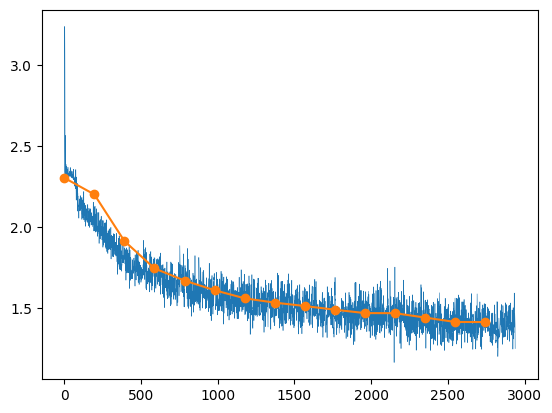

In [82]:
plt.plot(loss_history, linewidth=0.4)
plt.plot(np.arange(n_epochs) * epoch_size, loss_epoch, "-o")
plt.show()

# 2. Keras sequence
keras.utils.Sequence - спеціальний клас-генератор для вибірки, який можна подавати на вхід мереді замість навчальних даних (бо він всередині їх містить). Важливою властивістю його є те - що він дозволяє ітерувати по навчальним даним і: змінювати, аугментувати, завантажувати "на льоту".

Задача:
- збрежіть всі картинки у теку на жорсткому диску. 
- Створіть клас на основі keras.utils.Sequence та використайте його як генератор вибірки
- Цей новий клас прийматиме список шляхів до файлів
- Всередині цього нового класу картинки мають завантажуватися під всередині методу __getitem__ лише для вказаного батчу

Задачі по варіантам. Додайте аугментації:
1. Корекція тону (випадково)
2. Повороти на 90, 180, 270 градусів; 
3. додавайте нормальний шум з дисперсію 1 (якщо тон пікселів від 0 до 255), інакше - 0.001
4. Зрізайте картинку випадково так, щоб залишилося 14 на 14 пікселів. Робіть ресайз до 28х28
5. Відзеркалення зображень

Links:
- https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [62]:
# convert dataset format

out = input("Start conversion? ")
if out != "yes":
    raise RuntimeError()

from collections import defaultdict
import os

import torchvision.transforms.functional
class_counter = defaultdict(int) 

# for c in cifar.classes:
#     os.mkdir(f"data/cifar10/cifar-10-converted/{c}")

for i in tqdm(range(len(cifar))):
    item = cifar[i]
    img_array, label = item
    class_counter[label] += 1
    img = torchvision.transforms.functional.to_pil_image(img_array)
    
    img.save(f"data/cifar10/cifar-10-converted/{cifar.classes[label]}/{class_counter[label]}.png", "PNG")

RuntimeError: 

In [83]:
class CIFARFolderDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ColorJitter(0.1, 0.1, 0.1),
            torchvision.transforms.ToTensor()
        ])

        self._load_dataset()

    def _load_dataset(self):
        self.classes = sorted(os.listdir(self.root_dir)) 
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        for cls_name in self.classes:
            class_dir = os.path.join(self.root_dir, cls_name)
            if not os.path.isdir(class_dir):
                continue
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                if file_path.endswith(('.png')):  
                    self.image_paths.append(file_path)
                    self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        image = self.transforms(image) 

        return image, label


In [84]:
cifar_converted = CIFARFolderDataset("data/cifar10/cifar-10-converted")

# 3. Read from folder
Не завжди всі данні для навчання можливо вмістити у оперативну пам'ять. Для цього доводиться зберігати їх на жорсткому диску, та завантажувати по необхідності

- Навчіть 10 ітерацій 
- скільки часу витрачено?

Таким чином, вам потрібно буде більше часу на навчання, але великі об'ємі даних тепер - не є завадою



Links:
- https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [85]:
batch_size = 256 
n_epochs = 15 
dataloader = DataLoader(cifar_converted, batch_size=batch_size, shuffle=True)

In [86]:
torch.manual_seed(42)
model.reset_params()
model = model.to(device)

In [87]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)


loss_history = []
loss_epoch = []
epoch_size = len(dataloader)
data_iterator = iter(dataloader)

for it in tqdm(range(epoch_size * n_epochs)):
    try:
        inputs, labels = next(data_iterator) 
    except StopIteration:
        data_iterator = iter(dataloader)
        inputs, labels = next(data_iterator) 

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    out = model(inputs)
    loss = loss_fn(out, labels)

    loss_history.append(loss.item())

    loss.backward()
    optimizer.step()

    if it % epoch_size == 0:
        loss_epoch.append(np.mean(loss_history[-epoch_size:]))

100%|██████████| 2940/2940 [05:37<00:00,  8.71it/s]


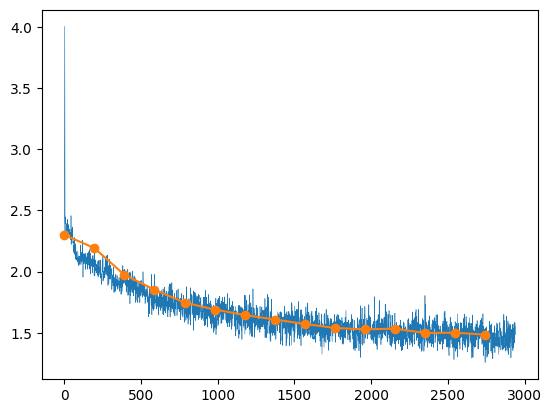

In [88]:
plt.plot(loss_history, linewidth=0.4)
plt.plot(np.arange(n_epochs) * epoch_size, loss_epoch, "-o")
plt.show()

# 4. Tensorstore

Дійсно, кожен раз завантажувати дані - то повільно. Зараз ми з вами збережемо їх послідовно на жорсткому диску, що дозволить нам значно швидше їх зчитувати. Для цього використаємо фреймворк Tensorstore. Робота з ним нагадуватиме роботу із numpy

- Використайте tensorstore, творіть сховище (4-вимірний масив)
- Покладіть картинки у сховище
- Створіть ще один аналог keras.utils.Sequence, та зчитуйте картинки із вашого tensorstore
- Навчіть модель, та поміряйте час

Links:
- https://google.github.io/tensorstore/python/tutorial.html

In [137]:
import tensorstore as ts

root_dir, storage_path = "data/cifar10/cifar-10-converted", "data/cifar10/cifar-10-ts"
image_paths = []
labels = []
classes = sorted(os.listdir(root_dir))
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

for cls_name in classes:
    class_dir = os.path.join(root_dir, cls_name)
    if not os.path.isdir(class_dir):
        continue
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        if file_path.endswith('.png'):
            image_paths.append(file_path)
            labels.append(class_to_idx[cls_name])

images = [np.array(Image.open(img).convert("RGB")) for img in image_paths]
images = np.stack(images).astype("uint8")  # (N, H, W, C)
labels = np.array(labels)  # (N,)

storage = ts.open({
    'driver': 'zarr',
    'kvstore': {'driver': 'file', 'path': storage_path},
    'metadata': {
        'dtype': '|u1',
        'shape': images.shape,
        'chunks': [1000, 32, 32, 3],
        # 'order': 'C',
    },
    'create': True,
    'delete_existing': True
}).result()
storage[...] = images

In [152]:
class CIFARTensorStoreDataset(Dataset):
    def __init__(self, image_ts, labels):
        self.image_ts = image_ts
        self.label_ts = labels

        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ColorJitter(0.1, 0.1, 0.1),
            torchvision.transforms.ToTensor()
        ])

    def __len__(self):
        return self.image_ts.shape[0]

    def __getitem__(self, idx):
        image = np.array(self.image_ts[idx])
        label = int(self.label_ts[idx])

        image = Image.fromarray(image)  
        image = self.transforms(image)  

        return image, label

In [153]:
cifar10ts = CIFARTensorStoreDataset(storage, labels)

In [154]:
batch_size = 256 
n_epochs = 15 
dataloader = DataLoader(cifar10ts, batch_size=batch_size, shuffle=True)

In [155]:
next(iter(dataloader))

[tensor([[[[0.3922, 0.4314, 0.5098,  ..., 1.0000, 1.0000, 1.0000],
           [0.3490, 0.4078, 0.5373,  ..., 1.0000, 1.0000, 1.0000],
           [0.3059, 0.3098, 0.3647,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [0.1529, 0.1333, 0.1569,  ..., 0.3137, 0.3373, 0.3647],
           [0.0784, 0.0627, 0.1098,  ..., 0.2196, 0.3333, 0.3725],
           [0.0941, 0.0980, 0.1216,  ..., 0.2353, 0.3333, 0.3882]],
 
          [[0.3804, 0.4196, 0.4941,  ..., 1.0000, 1.0000, 1.0000],
           [0.3333, 0.3922, 0.5216,  ..., 1.0000, 1.0000, 1.0000],
           [0.2941, 0.2980, 0.3529,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [0.1373, 0.1569, 0.1412,  ..., 0.2784, 0.3020, 0.3216],
           [0.0627, 0.0745, 0.0784,  ..., 0.1765, 0.2824, 0.3216],
           [0.0824, 0.0980, 0.0824,  ..., 0.1804, 0.2784, 0.3333]],
 
          [[0.3686, 0.4039, 0.4824,  ..., 1.0000, 1.0000, 1.0000],
           [0.3294, 0.3882, 0.5176,  ..., 1.0000, 1.0000, 1.0000],
           [0.2980, 0.30

In [156]:
torch.manual_seed(42)
model.reset_params()
model = model.to(device)

In [135]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)


loss_history = []
loss_epoch = []
epoch_size = len(dataloader)
data_iterator = iter(dataloader)

for it in tqdm(range(epoch_size * n_epochs)):
    try:
        inputs, labels = next(data_iterator) 
    except StopIteration:
        data_iterator = iter(dataloader)
        inputs, labels = next(data_iterator) 

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    out = model(inputs)
    loss = loss_fn(out, labels)

    loss_history.append(loss.item())

    loss.backward()
    optimizer.step()

    if it % epoch_size == 0:
        loss_epoch.append(np.mean(loss_history[-epoch_size:]))

  2%|▏         | 62/2940 [01:20<1:02:05,  1.29s/it]


KeyboardInterrupt: 

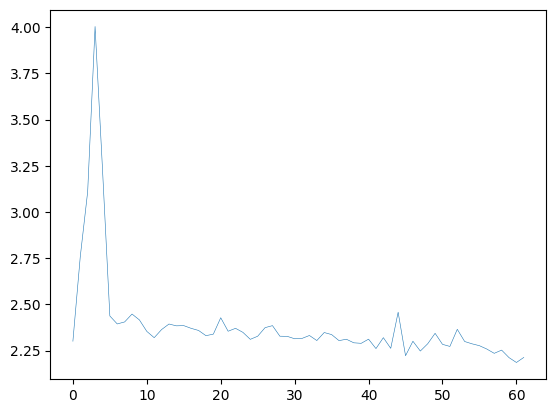

In [ ]:
plt.plot(loss_history, linewidth=0.4)
plt.plot(np.arange(n_epochs) * epoch_size, loss_epoch, "-o")
plt.show()

# 5. Keras dataset loader

В бібліотеці tensorstore є спеціальні методи для того, щоб читати дані із файлової системи 9та змінювати їх "на льоту".

Завдання:
- Використайте раніше збережені картинки у теці, та побудуйте data loader для них
- Навчіть модель, та поміряйте час

Links:
- https://keras.io/api/data_loading/

In [169]:
batch_size = 256 
n_epochs = 15 
cifarif = ImageFolder("data/cifar10/cifar-10-converted", transform=torchvision.transforms.ToTensor())
dataloader = DataLoader(cifarif, batch_size=batch_size, shuffle=True)

In [170]:
torch.manual_seed(42)
model.reset_params()
model = model.to(device)

In [171]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)


loss_history = []
loss_epoch = []
epoch_size = len(dataloader)
data_iterator = iter(dataloader)

for it in tqdm(range(epoch_size * n_epochs)):
    try:
        inputs, labels = next(data_iterator) 
    except StopIteration:
        data_iterator = iter(dataloader)
        inputs, labels = next(data_iterator) 

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    out = model(inputs)
    loss = loss_fn(out, labels)

    loss_history.append(loss.item())

    loss.backward()
    optimizer.step()

    if it % epoch_size == 0:
        loss_epoch.append(np.mean(loss_history[-epoch_size:]))

100%|██████████| 2940/2940 [02:30<00:00, 19.48it/s]


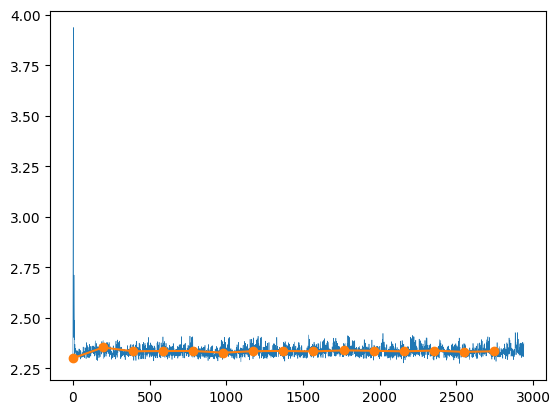

In [172]:
plt.plot(loss_history, linewidth=0.4)
plt.plot(np.arange(n_epochs) * epoch_size, loss_epoch, "-o")
plt.show()

# Висновки

Напишіть висновки:
- Який підхід був найзручніший?
- Який підхід дав змогу навчати модельі швидше?

Найшвидше напряму з памʼяті, буде ще швидше якщо датасет в гпу памʼять завантажити, але на практиці не має сенсу

Найзручніше або свій датасет або ImageFolder